In [1]:
import matplotlib.pyplot as plt
import torch
from PIL import Image
import numpy as np
import json
import os
from modules.model import InstanceSegmentation
from modules.viz import viz_origin_boxes_masks, viz_history

# Dataset

Dataset comes from two sources:

### WHU Building Dataset (Aerial Imagery)
The main training dataset is the WHU Building Dataset, provided by the Photogrammetry and Computer Vision Group at Wuhan University. We used the aerial imagery subset, which is based on data from the New Zealand Land Information Services (LINZ).

### Scraped Poznań Aerial Images (Geoportal Poland)
The second dataset consists of aerial images downloaded from the Polish National Geoportal.

<table>
    <tbody>
        <tr>
            <td><b>Attribute</b></td>
            <td><b>WHU-Building-Dataset</b></td>
            <td><b>Scraped Poznań images</b></td>
            <td><b>Total</b></td>
        </tr>
        <tr>
            <td>Size</td>
            <td>15 GB</td>
            <td>15 GB</td>
            <td>30 GB</td>
        </tr>
        <tr>
            <td>Source</td>
            <td>https://gpcv.whu.edu.cn/data/building_dataset.html</td>
            <td>https://www.geoportal.gov.pl/</td>
            <td></td>
        </tr>
        <tr>
            <td>Location</td>
            <td>Christchurch, New Zealand</td>
            <td>Western part of Poznań, Poland</td>
            <td></td>
        </tr>
        <tr>
            <td>Number of images</td>
            <td>5790</td>
            <td>5000</td>
            <td></td>
        </tr>
        <tr>
            <td>Image size</td>
            <td>1024 × 1024 px</td>
            <td>1024 × 1024 px</td>
            <td></td>
        </tr>
        <tr>
            <td>Spatial resolution</td>
            <td>0.3 m per pixel</td>
            <td>0.25 m per pixel</td>
            <td></td>
        </tr>
    </tbody>
</table>

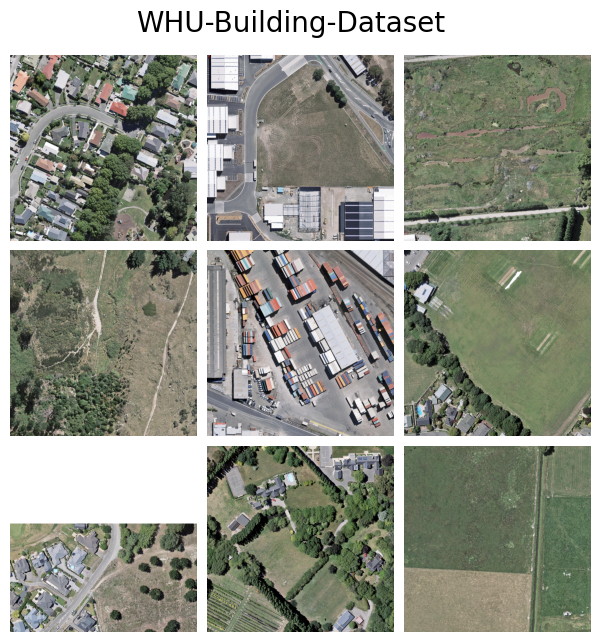

In [2]:
NROWS = 3
NCOLS = 3
fig, ax = plt.subplots(ncols=NROWS, nrows=NCOLS, figsize=(2.5*NROWS, 2.5*NCOLS))
imgs_paths = [
    f"./data/WHU-Building-Dataset/imgs/{img_name}" for img_name in
    np.random.choice(os.listdir("./data/WHU-Building-Dataset/imgs"), size=18)
]
for c in range(NROWS):
    for r in range(NCOLS):
        img_path = imgs_paths[r*NROWS + c]
        img = Image.open(img_path)
        ax[r][c].imshow(img)
        ax[r][c].axis(False)

plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.suptitle("WHU-Building-Dataset", y=0.94, fontsize=20)
plt.show()

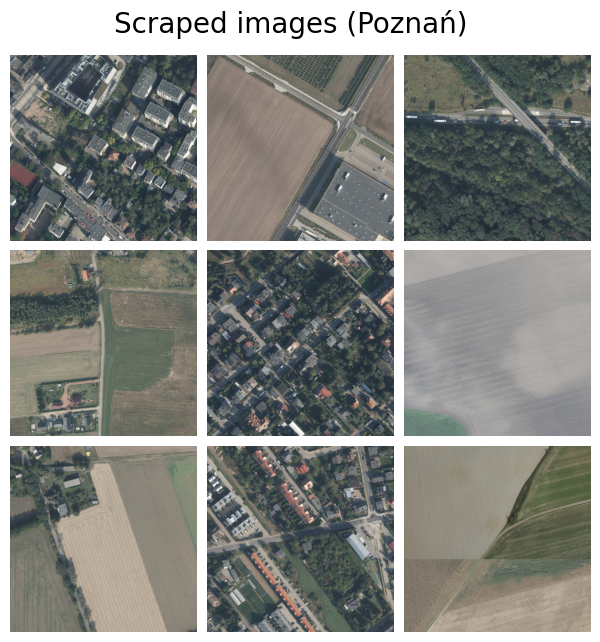

In [3]:
NROWS = 3
NCOLS = 3
fig, ax = plt.subplots(ncols=NROWS, nrows=NCOLS, figsize=(2.5*NROWS, 2.5*NCOLS))
imgs_paths = [
    f"./data/scraping/imgs/{img_name}" for img_name in
    np.random.choice(os.listdir("./data/scraping/imgs"), size=18)
]
for c in range(NROWS):
    for r in range(NCOLS):
        img_path = imgs_paths[r*NROWS + c]
        img = Image.open(img_path)
        ax[r][c].imshow(img)
        ax[r][c].axis(False)

plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.suptitle("Scraped images (Poznań)", y=0.94, fontsize=20)
plt.show()

# The problem

The goal of the instance segmentation model is to automatically detect and segment individual buildings in high-resolution aerial imagery. Unlike semantic segmentation, which labels all building pixels as a single class, instance segmentation aims to separate and delineate each building as a distinct object, even when buildings are adjacent or overlapping in dense urban areas.

# Model

### Architecture

**Mask R-CNN** architecture proposed here https://arxiv.org/abs/1703.06870

<center>
    <img src="./docs/architecture.png" width="60%">
</center>

```python
class MaskDetector(nn.Module):
    def __init__(self, num_classes=2):
        super(MaskDetector, self).__init__()
        
        # 1. Load Pretrained Backbone (ResNet50)
        backbone_base = resnet50(weights=ResNet50_Weights.DEFAULT)
        self.backbone_features = nn.Sequential(*list(backbone_base.children())[:-2])
        self.backbone_features.out_channels = 2048
        
        # 2. Define Anchor Generator
        anchor_sizes = ((32, 64, 128, 256, 512),) 
        aspect_ratios = ((0.5, 1.0, 2.0),)
        rpn_anchor_generator = AnchorGenerator(sizes=anchor_sizes, aspect_ratios=aspect_ratios)
        
        # 3. Define ROI Pooler for Boxes
        box_roi_pool = MultiScaleRoIAlign(
            featmap_names=['0'],
            output_size=7,
            sampling_ratio=2
        )
        
        # 4. Define ROI Pooler for Masks (New for Mask R-CNN)
        mask_roi_pool = MultiScaleRoIAlign(
            featmap_names=['0'],
            output_size=14,
            sampling_ratio=2
        )
        
        # 5. Assemble Mask R-CNN
        self.model = MaskRCNN(
            self.backbone_features,
            num_classes=num_classes,
            rpn_anchor_generator=rpn_anchor_generator,
            box_roi_pool=box_roi_pool,
            mask_roi_pool=mask_roi_pool
        )

    def forward(self, images, targets=None):
        return self.model(images, targets)
```

### Size of model

Weight of the model: 672.197 MB

Parameters: 171 985 815

<table>
    <tbody>
        <tr>
            <td>Module</td>
            <td>Parameters</td>
        </tr>
        <tr>
            <td>Backbone</td>
            <td style="text-align: right">23 508 032</td>
        </tr>
        <tr>
            <td>RPN</td>
            <td style="text-align: right">37 904 459</td>
        </tr>
        <tr>
            <td>Box Head</td>
            <td style="text-align: right">103 821 322</td>
        </tr>
        <tr>
            <td>Mask Head</td>
            <td style="text-align: right">6 752 002</td>
        </tr>
    </tbody>
</table>

# Metrics

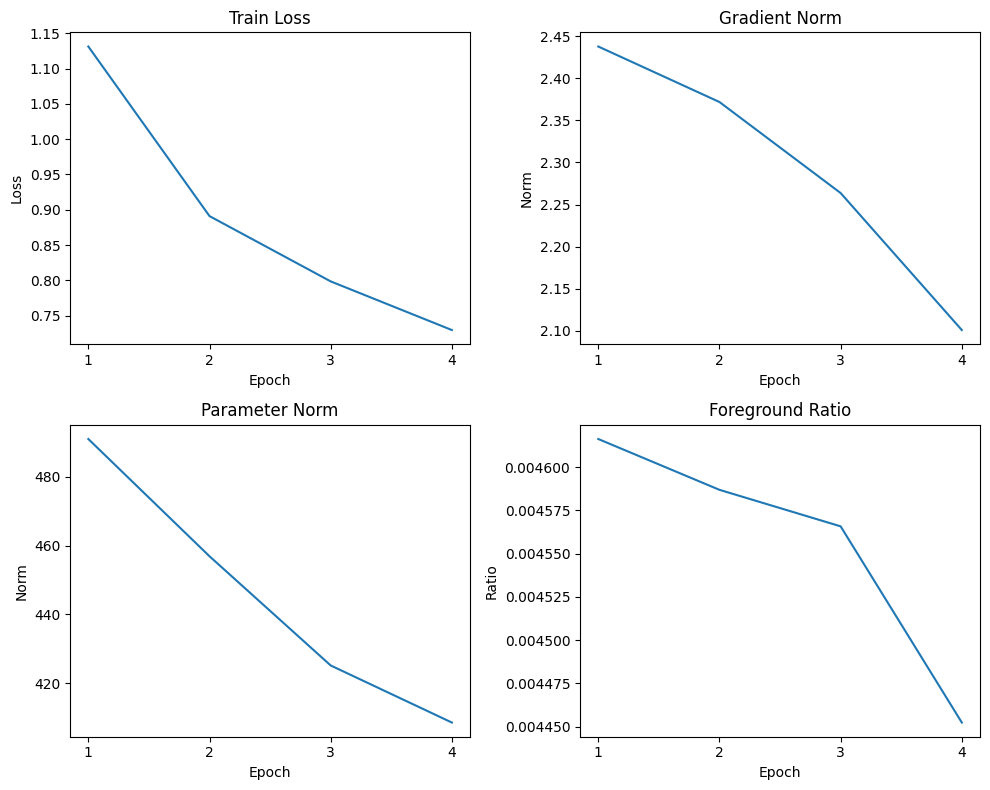

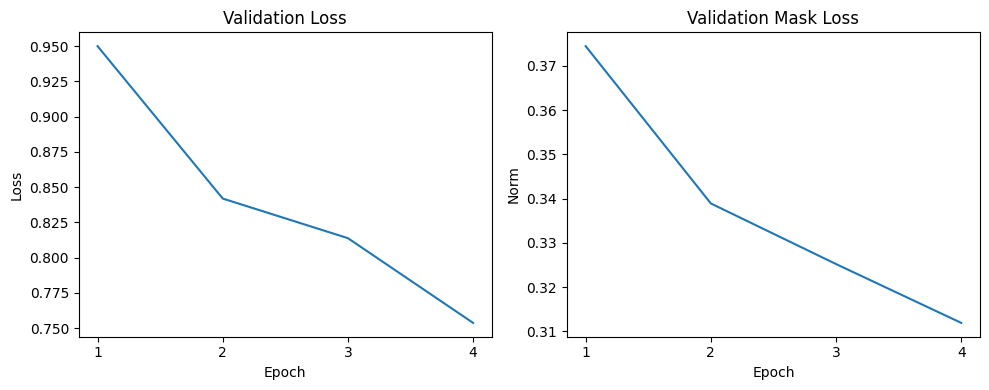

In [4]:
with open("./data/history.json", "r") as f:
    history = json.load(f)

viz_history(history)

### 1. Train Loss
Measures how well the model fits the training data by minimizing the sum of all task-specific losses (classification, box regression, mask, RPN). This is the objective optimized during training.  
$$
Loss_{\text{train}} = \sum_{i} \operatorname{mean}(Loss_i)
$$
```python
loss = sum(v.mean() for v in loss_dict.values())
```

### 2. Gradient Norm
Represents the overall magnitude of gradients across all model parameters and indicates optimization stability. Large values may signal exploding gradients, while very small values suggest vanishing gradients.  
<!-- $$
\|\nabla_{\theta} Loss\|_2 = \sqrt{\sum_{p \in \theta} \left\| \frac{\partial Loss}{\partial p} \right\|_2^2}
$$ -->
```python
grad_norm = torch.sqrt(sum(p.grad.norm(2)**2 for p in model.parameters() if p.grad is not None))
```

### 3. Parameter Norm
Measures the magnitude of model weights after an optimization step, reflecting how large the learned parameters are. It helps detect weight explosion or overly strong regularization.  
<!-- $$
\|\theta\|_2 = \sqrt{\sum_{p \in \theta} \|p\|_2^2}
$$ -->
```python
param_norm = torch.sqrt(sum(p.data.norm(2)**2 for p in model.parameters()))
```

### 4. Foreground Ratio (FG Ratio)
Describes the fraction of foreground (object) pixels in ground-truth masks, indicating dataset sparsity and class imbalance rather than model quality.  
$$
\text{FG Ratio} = \frac{\sum \mathbf{1}(m = 1)}{\sum \mathbf{1}}
$$
```python
fg_ratio = masks.float().mean()
```

### 5. Validation Loss
Computes the same total loss as training loss but on unseen validation data, measuring how well the model generalizes beyond the training set.  
$$
Loss_{\text{val}} = \sum_{i} \operatorname{mean}(Loss_i \mid \mathcal{D}_{\text{val}})
$$
```python
val_loss = sum(v.mean() for v in loss_dict.values())
```

### 6. Validation Mask Loss
Evaluates only the segmentation (mask) loss on validation data, isolating pixel-level mask quality independent of detection and classification performance.  
$$
Loss_{\text{mask,val}} = \operatorname{mean}(Loss_{\text{mask}} \mid \mathcal{D}_{\text{val}})
$$

```python
val_mask_loss = loss_dict["loss_mask"].mean()
```

# Hyperparameters

For traning we set learning rate scheduler:
```python
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
```
Initial learning rate is `0.005` and after each epoch learning rate is 2 time smaller.

# Example results

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = InstanceSegmentation()
checkpoint = torch.load("./models/instance_segmentation/instance_segmentation_4.pth", map_location=device)
model.load_state_dict(checkpoint)
model.to(device)
model.eval()
pass

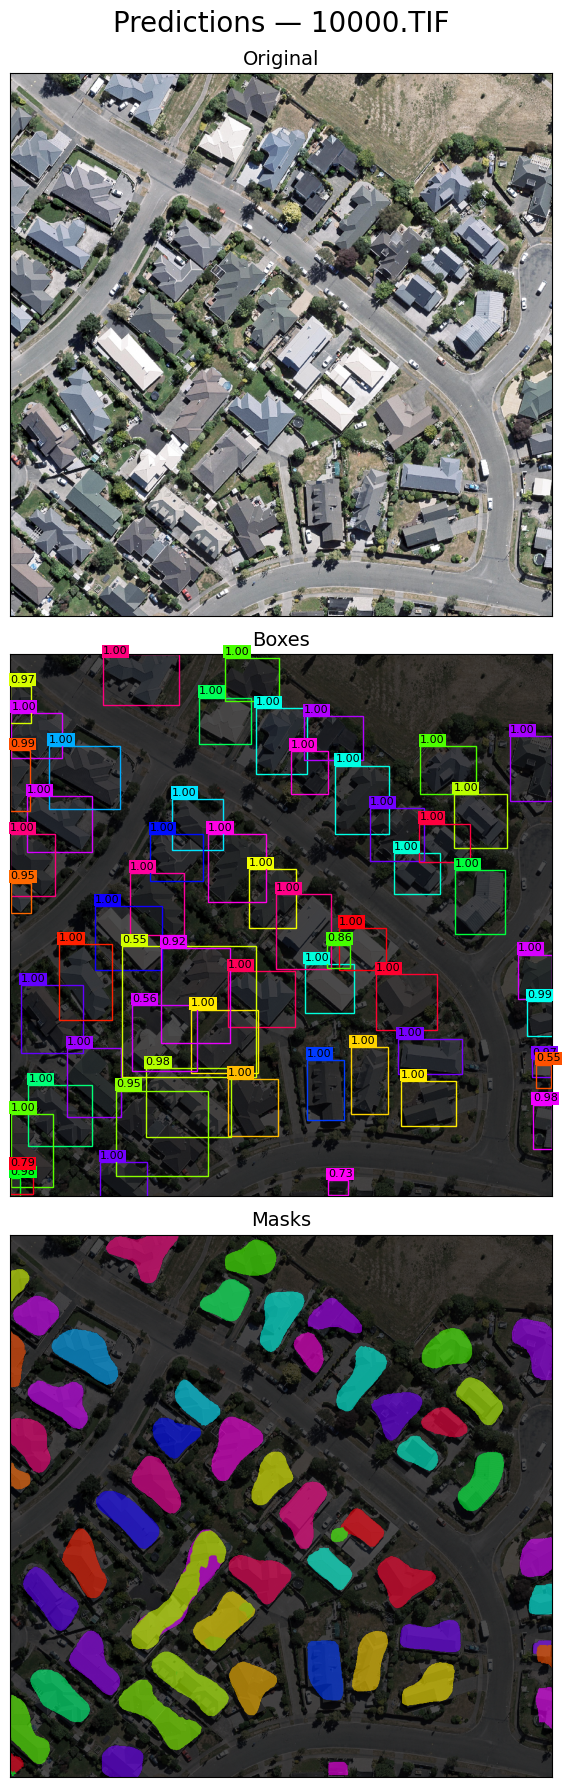

In [9]:
viz_origin_boxes_masks("./data/WHU-Building-Dataset/imgs/10000.TIF", model, device)

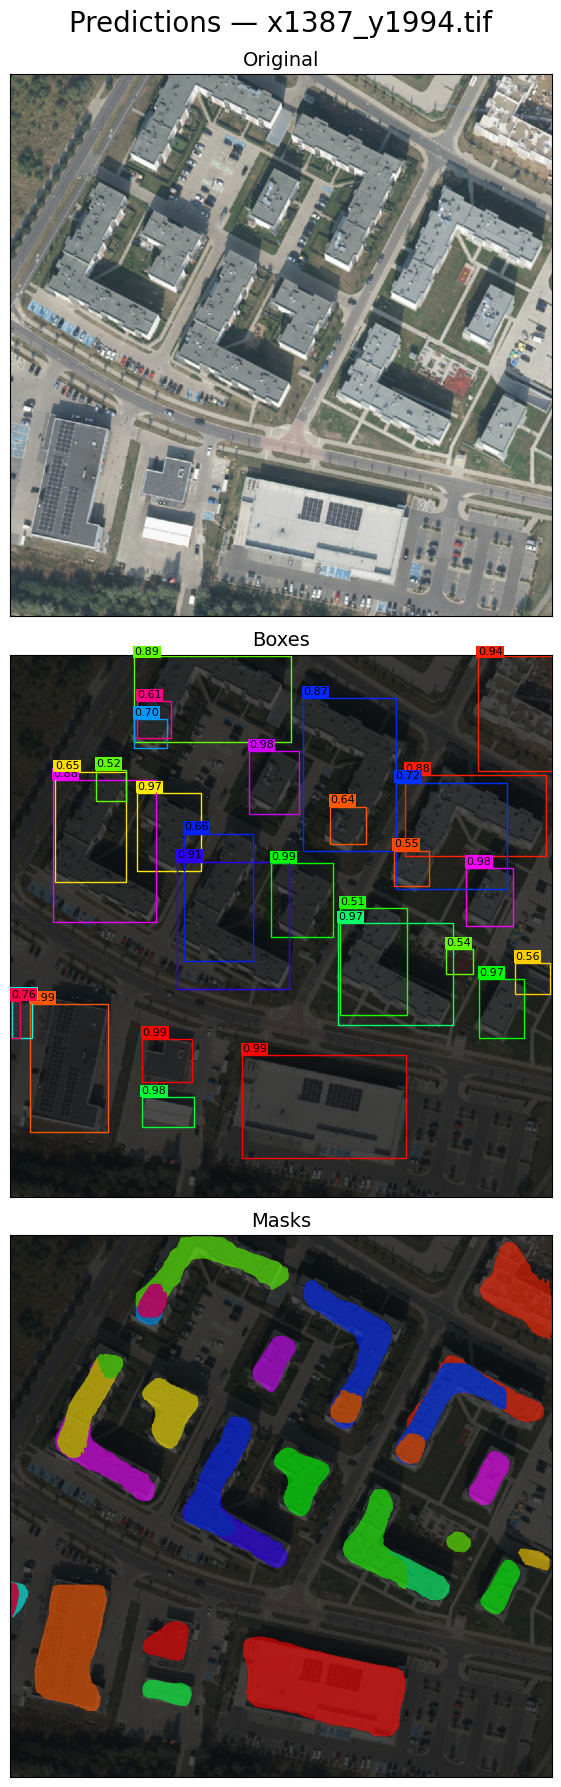

In [7]:
viz_origin_boxes_masks("./data/scraping/imgs/x1387_y1994.tif", model, device)

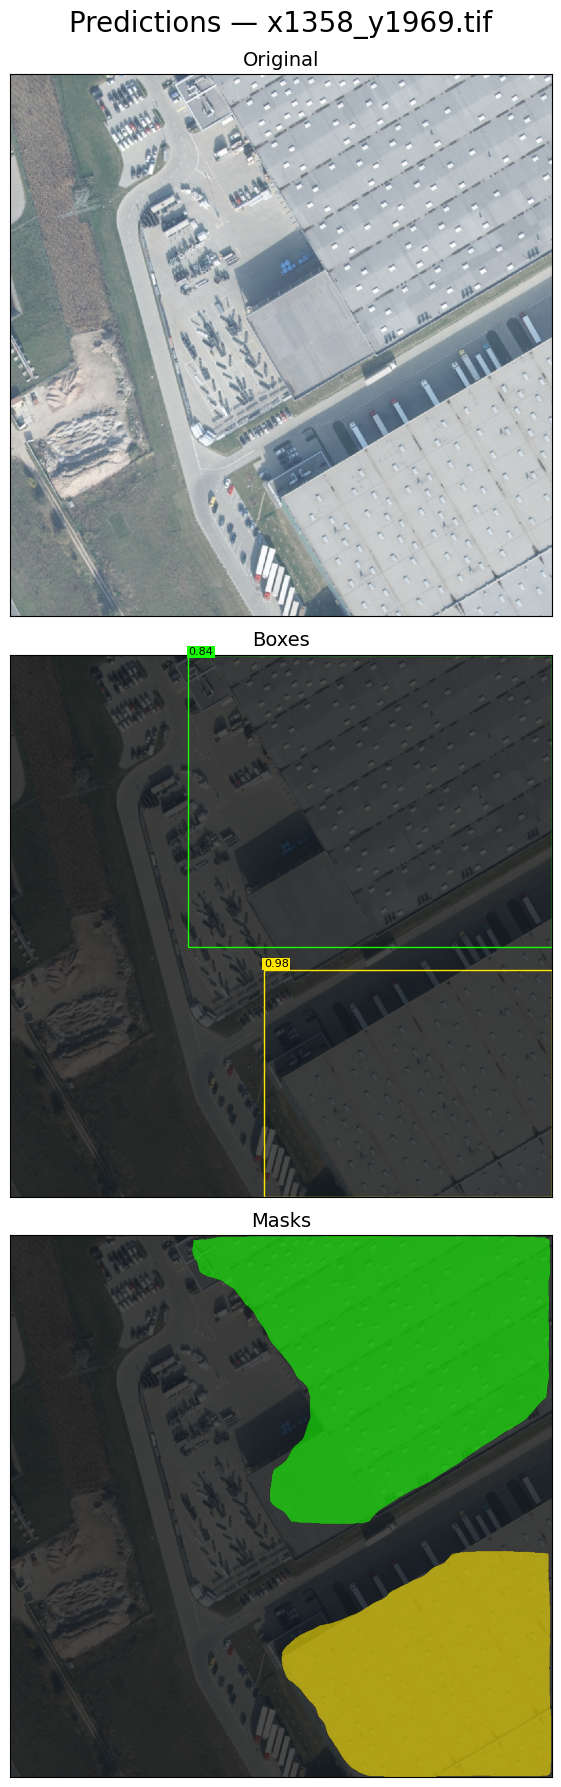

In [8]:
viz_origin_boxes_masks("./data/scraping/imgs/x1358_y1969.tif", model, device, threshold=0.7)

# References

### Data source:
- https://gpcv.whu.edu.cn/data/building_dataset.html
- https://www.geoportal.gov.pl/

### Information sources:
- https://arxiv.org/abs/1703.06870
- https://arxiv.org/abs/1506.01497